<a href="https://colab.research.google.com/github/gabrielxcosta/PCC142---Data-Mining/blob/main/Project/projeto_MD_Gabriel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!pip install fuzzywuzzy python-Levenshtein

In [92]:
import os
import re
import json
import zipfile
import kagglehub
import numpy as np
import pandas as pd
import pickle as pk
import seaborn as sns
import networkx as nx
import geopandas as gpd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from shapely.geometry import Point
from matplotlib.colors import to_rgb
import matplotlib.patches as mpatches
from shapely.geometry import LineString
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from sklearn.experimental import enable_iterative_imputer
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.impute import IterativeImputer

In [93]:
path = kagglehub.dataset_download("jonbown/london-tube-station-usage")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/london-tube-station-usage


In [94]:
os.listdir(path)

['2011_Entry_Exit.csv',
 '2010_Entry_Exit.csv',
 '2008_Entry_Exit.csv',
 '2013_Entry_Exit.csv',
 '2012_Entry_Exit.csv',
 '2007_Entry_Exit.csv',
 '2009_Entry_Exit.csv',
 '2014_Entry_Exit.csv',
 'stations.json',
 '2016_Entry_Exit.csv',
 '2017_Entry_Exit.csv',
 '2015_Entry_Exit.csv']

# London Underground Station Usage

Este dataset do Kaggle fornece informações sobre o uso das estações do metrô de Londres (**London Underground**), com dados de entrada e saída de passageiros por estação. As contagens são fornecidas separadamente para dias úteis, sábados e domingos, além de um valor total anual estimado de uso por estação.

### Importante sobre as Contagens:

As colunas de entrada e saída **não representam totais anuais**, mas sim **valores típicos para um único dia** de operação. Para estimar os totais anuais, é utilizado o seguinte peso:

- **Dias úteis**: 253
- **Sábados**: 52
- **Domingos**: 59  
*(Pressupõe 364 dias no ano, tratando 7 feriados como domingos e excluindo o Natal)

O total anual estimado é calculado como:


$\text{Total Anual} = (Entry\_Week + Exit\_Week) \times 253 + (Entry\_Saturday + Exit\_Saturday) \times 52 + (Entry\_Sunday + Exit\_Sunday) \times 59$

> Observação: A soma total de entradas e saídas em todo o sistema **não é igual** devido a variações na coleta dos dados, dias diferentes de contagem e inclusão eventual de passageiros de serviços ferroviários nacionais (NR).

---

### Coluna de Observações (`Note`):

Esta coluna indica anomalias nos dados de algumas estações:

- **N**: Estação fechada
- **T**: Os números incluem todos os passageiros da linha W&C (que fica fechada aos domingos)
- **B**: Os números para Bank/Monument agora excluem passageiros da linha W&C em transferência
- **A**: Contagens do ano anterior ajustadas pela variação média por zona

---

### Colunas do Dataset:

| Coluna                       | Descrição                                                                 | Tipo            |
|-----------------------------|---------------------------------------------------------------------------|-----------------|
| **nlc**                     | ID da estação (código numérico)                                          | `object`        |
| **Station Name**            | Nome da estação                                                          | `object`        |
| **Borough**                 | Nome do bairro ou região onde a estação está localizada                  | `object`        |
| **Note**                    | Observações sobre a contagem de dados                                    | `object`        |
| **Entry_Week**              | Total típico de entradas em um dia útil                                  | `float64`       |
| **Entry_Saturday**          | Total típico de entradas em um sábado                                    | `float64`       |
| **Entry_Sunday**            | Total típico de entradas em um domingo                                   | `float64`       |
| **Exit_Week**               | Total típico de saídas em um dia útil                                    | `float64`       |
| **Exit_Saturday**           | Total típico de saídas em um sábado                                      | `float64`       |
| **Exit_Sunday**             | Total típico de saídas em um domingo                                     | `float64`       |
| **AnnualEntryExit_Mill**    | Total anual estimado de entradas + saídas (em milhões)                   | `float64`       |
| **date**                    | Ano da contagem (em formato de período anual)                            | `period[Y-DEC]` |
| **Entry_Week_norm**         | Entrada em dia útil, normalizada (escala comparativa entre estações)     | `float64`       |
| **Exit_Week_norm**          | Saída em dia útil, normalizada                                           | `float64`       |
| **AnnualEntryExit_Mill_norm** | Total anual de fluxo, normalizado                                      | `float64`       |
| **Total_Weekday**           | Soma de entradas e saídas em dias úteis                                  | `float64`       |
| **Total_Weekend**           | Soma de entradas e saídas no fim de semana                               | `float64`       |
| **Ratio_Weekend_Weekday**   | Razão entre o fluxo de fim de semana e dias úteis                        | `float64`       |
| **year**                    | Ano extraído da coluna `date`                                            | `int64`         |
| **lat**                     | Latitude da estação                                                      | `float64`       |
| **lon**                     | Longitude da estação                                                     | `float64`       |
| **geometry**                | Geometria do ponto geográfico (latitude, longitude)                      | `geometry`      |
| **msoa21cd**                | Código da área estatística (MSOA 2021)                                   | `object`        |
| **msoa21nm**                | Nome da área estatística (MSOA 2021)                                     | `object`        |
| **lad22cd**                 | Código do distrito administrativo local (LAD 2022)                       | `object`        |
| **lad22nm**                 | Nome do distrito administrativo local (LAD 2022)                         | `object`        |

### Arquivo Geoespacial (Complementar)

Um segundo arquivo JSON é fornecido com coordenadas geográficas para visualização em mapas. Ele contém três chaves principais:

- **stations**: Nomes das estações e suas coordenadas (latitude e longitude)
- **lines**: Geometria das linhas do metrô (ex: Central, District, etc.)
- **river**: Traçado do rio Tâmisa (Thames)

Esse arquivo é útil para criar mapas estilizados no estilo clássico do metrô de Londres.

> Obs.: Os dados foram atualizados apenas até 2017. Assim que a TFL (Transport for London) disponibilizar dados mais recentes, o autor pretende atualizá-los no Kaggle.

# Fase 1 - Pré-processamento e transformação

## Agrupando os dados anuais

In [95]:
files = os.listdir(path)
pattern = re.compile(r'(\d{4})_Entry_Exit\.csv')
df_list = []

for filename in files:
    match = pattern.match(filename)
    if match:
        year = int(match.group(1))
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path)
        df['date'] = pd.Period(f'{year}', freq='Y')
        df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)
full_df

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,date,Borough,Unnamed: 11
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,2011,NaN,NaN
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,2011,NaN,NaN
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,2011,NaN,NaN
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,2011,NaN,NaN
4,506,Amersham,,3461.0,1496.0,975.0,3775.0,1582.0,869.0,2.100000,2011,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,2015,Merton,NaN
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,2015,Haringey,NaN
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,2015,Hammersmith and Fulham,NaN
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,2015,Redbridge,NaN


In [96]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   nlc                   2955 non-null   object       
 1   Station               2953 non-null   object       
 2   Note                  2242 non-null   object       
 3   Entry_Week            2953 non-null   float64      
 4   Entry_Saturday        2953 non-null   float64      
 5   Entry_Sunday          2953 non-null   float64      
 6   Exit_Week             2953 non-null   float64      
 7   Exit_Saturday         2953 non-null   float64      
 8   Exit_Sunday           2953 non-null   float64      
 9   AnnualEntryExit_Mill  2952 non-null   float64      
 10  date                  2955 non-null   period[Y-DEC]
 11  Borough               1072 non-null   object       
 12  Unnamed: 11           0 non-null      float64      
dtypes: float64(8), object(4), period[

## Análise descritiva e pré-processamento

### Estatísticas descritivas básicas


In [97]:
full_df.describe(include='all')  # Inclui estatísticas para colunas não numéricas

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,date,Borough,Unnamed: 11
count,2955.0,2953,2242,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.00000,2952.000000,2955,1072,0.0
unique,544.0,883,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,31,NaN
top,771.0,Heathrow Terminals 123,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,City of Westminster,NaN
freq,9.0,10,1888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,124,NaN
mean,NaN,NaN,NaN,15832.458517,11222.802235,7556.190992,15585.829311,10913.880461,7354.04276,128.599217,NaN,NaN,NaN
std,NaN,NaN,NaN,21455.326175,16397.478007,11101.870239,21794.432258,16570.054653,10968.99336,656.292805,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,4482.000000,2835.000000,1846.000000,4203.000000,2583.000000,1753.00000,2.930000,NaN,NaN,NaN
50%,NaN,NaN,NaN,8453.000000,5625.000000,3805.000000,8099.000000,5227.000000,3610.00000,5.816754,NaN,NaN,NaN
75%,NaN,NaN,NaN,18038.000000,11736.000000,8406.000000,17574.000000,10864.000000,8045.00000,15.060000,NaN,NaN,NaN


### Verificar valores ausentes por coluna e imputar

In [98]:
full_df.isnull().sum()

,0
nlc,0
Station,2
Note,713
Entry_Week,2
Entry_Saturday,2
Entry_Sunday,2
Exit_Week,2
Exit_Saturday,2
Exit_Sunday,2
AnnualEntryExit_Mill,3


#### IterativeImputer

> Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

O **`IterativeImputer`** do `scikit-learn` é uma técnica de imputação de valores ausentes baseada em modelos preditivos. Ele preenche os valores ausentes de forma iterativa, tratando cada coluna com valores faltantes como uma variável a ser prevista usando as outras colunas como variáveis independentes.

#### Como funciona?

1. Inicializa os valores ausentes com um valor (como a média).
2. Para cada coluna com valores ausentes, utiliza um modelo (como regressão) para prever os valores ausentes com base nas outras colunas.
3. O processo é repetido várias vezes para melhorar a imputação.

### Vantagens

- Mais preciso que métodos simples (média/mediana).
- Refina a imputação em várias iterações.

In [99]:
full_df['Note'] = full_df['Note'].fillna('Normal')  # Preenche valores nulos na coluna 'Note' com o valor 'Normal'
full_df['Station'] = full_df['Station'].fillna('Desconhecida')  # Preenche valores nulos na coluna 'Station' com 'Desconhecida'

# Instanciando o IterativeImputer
iter_imputer = IterativeImputer(max_iter=1000, random_state=0)

# Imputando valores nas colunas numéricas
full_df[['Entry_Week', 'Entry_Saturday', 'Entry_Sunday', 'Exit_Week', 'Exit_Saturday', 'Exit_Sunday', 'AnnualEntryExit_Mill']] = iter_imputer.fit_transform(
    full_df[['Entry_Week', 'Entry_Saturday', 'Entry_Sunday', 'Exit_Week', 'Exit_Saturday', 'Exit_Sunday', 'AnnualEntryExit_Mill']]
)

full_df = full_df.drop(columns=['Unnamed: 11'])  # Remove a coluna 'Unnamed: 11', pois ela não contém dados úteis

# Confirmar
full_df.isnull().sum()

,0
nlc,0
Station,0
Note,0
Entry_Week,0
Entry_Saturday,0
Entry_Sunday,0
Exit_Week,0
Exit_Saturday,0
Exit_Sunday,0
AnnualEntryExit_Mill,0


#### Como imputar `Borough` usando scraping?

Uma abordagem possível para preencher os valores ausentes na coluna `Borough` é usar **web scraping** com `BeautifulSoup` e `requests`, consultando páginas da Wikipedia. A ideia é:

1. **Criar uma string de busca** combinando o nome da estação com `'station borough'`.
2. **Pesquisar no Google ou diretamente na Wikipedia** usando esse nome.
3. **Rastrear o HTML da página** da estação correspondente.
4. **Extrair o nome do borough** a partir da infobox ou do texto da introdução.
5. **Atualizar a coluna `Borough` no DataFrame** com o valor obtido.

> ⚠️ Importante: Esse processo deve respeitar as regras de uso dos sites e pode exigir tratamento de exceções, limites de requisição e ajustes manuais.

Como alternativa automatizada e mais robusta, também é possível usar APIs como a do OpenStreetMap (Nominatim) ou consultar dados geográficos oficiais do Transport for London (TfL).


### Distribuição das entradas e saídas semanais de cada ano

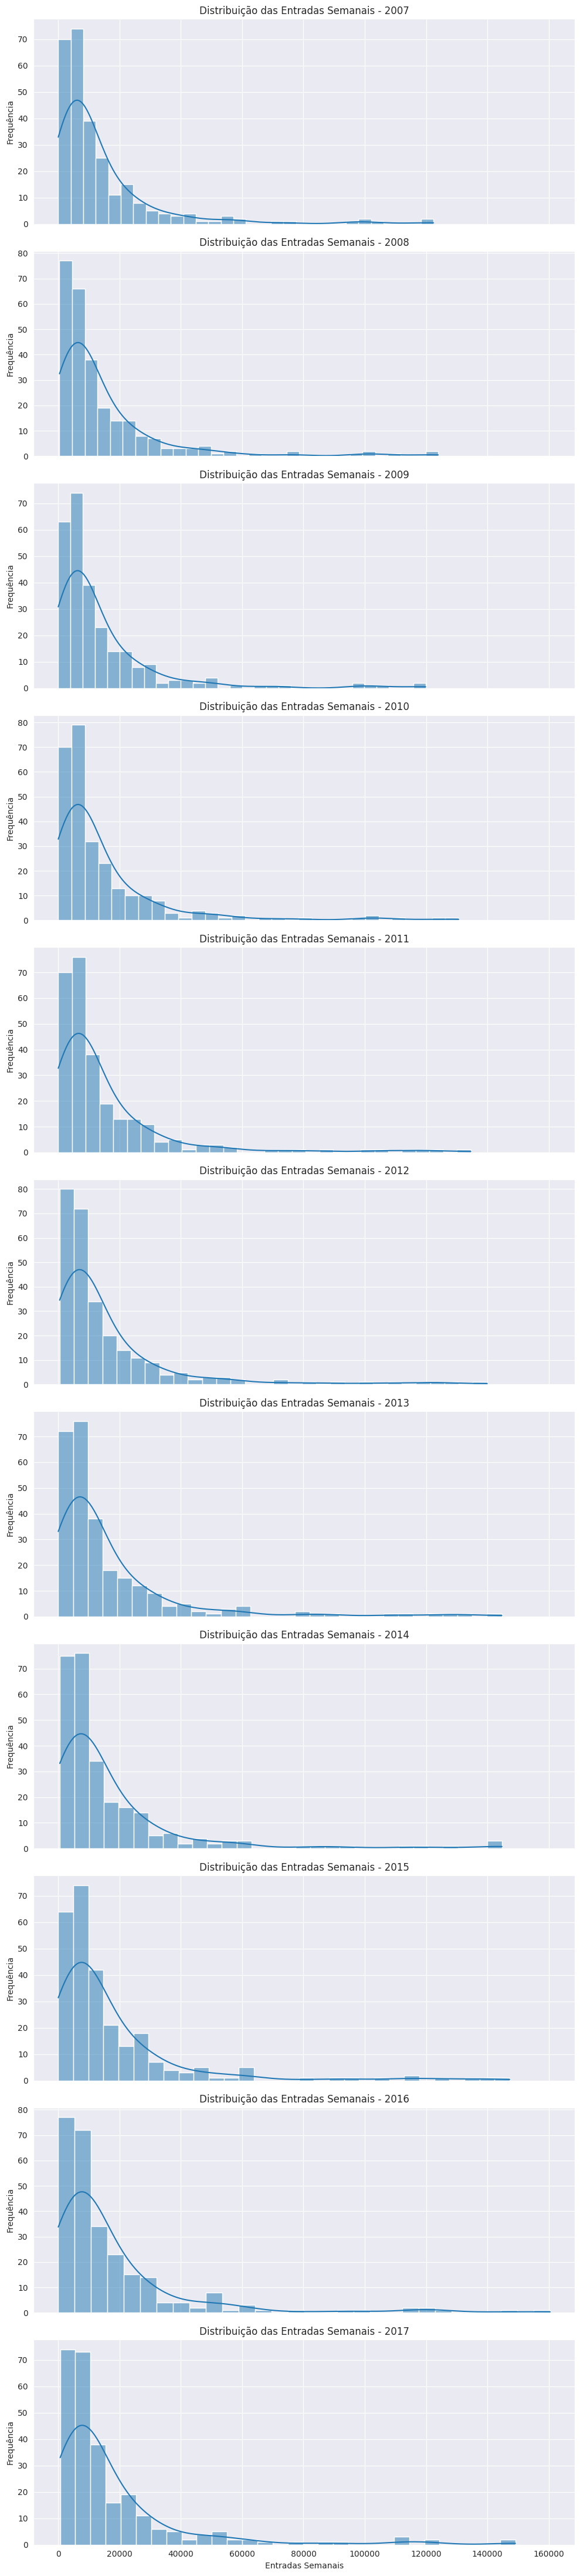

In [100]:
years = sorted(full_df['date'].unique())
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(10, 4 * n_years), sharex=True)

for i, year in enumerate(years):
    sns.histplot(full_df[full_df['date'] == year]['Entry_Week'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição das Entradas Semanais - {year}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequência')

axes[-1].set_xlabel('Entradas Semanais')
plt.tight_layout()
plt.show()

### Top 10 estações com maior movimento anual

In [101]:
top_stations = full_df.sort_values(by='AnnualEntryExit_Mill', ascending=False).head(10)
print(top_stations[['Station', 'AnnualEntryExit_Mill']])

                       Station  AnnualEntryExit_Mill
2547  King's Cross St. Pancras              12208.11
2663                  Waterloo              10569.46
2588             Oxford Circus              10417.31
2658                  Victoria               9727.26
2558             London Bridge               8204.75
2637                 Stratford               8112.43
2557          Liverpool Street               7652.50
2430           Bank & Monument               6171.74
2589                Paddington               5776.20
2455              Canary Wharf               5537.58


In [102]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   nlc                   2955 non-null   object       
 1   Station               2955 non-null   object       
 2   Note                  2955 non-null   object       
 3   Entry_Week            2955 non-null   float64      
 4   Entry_Saturday        2955 non-null   float64      
 5   Entry_Sunday          2955 non-null   float64      
 6   Exit_Week             2955 non-null   float64      
 7   Exit_Saturday         2955 non-null   float64      
 8   Exit_Sunday           2955 non-null   float64      
 9   AnnualEntryExit_Mill  2955 non-null   float64      
 10  date                  2955 non-null   period[Y-DEC]
 11  Borough               1072 non-null   object       
dtypes: float64(7), object(4), period[Y-DEC](1)
memory usage: 277.2+ KB


### Correlação entre as variáveis

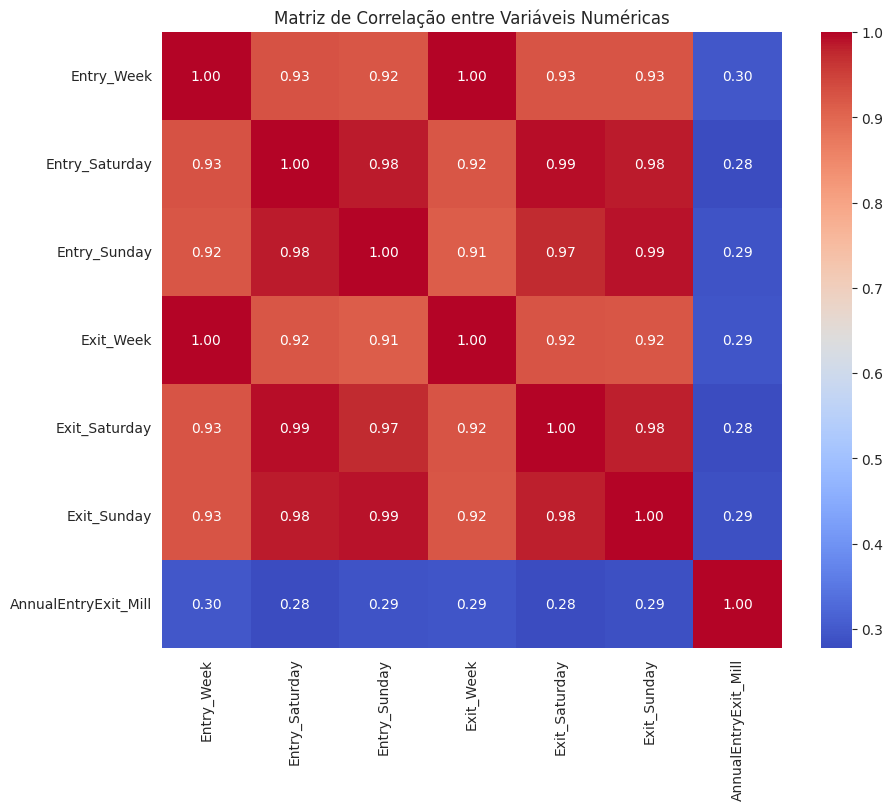

In [103]:
# Matriz de correlação
correlation_matrix = full_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

### Boxplots

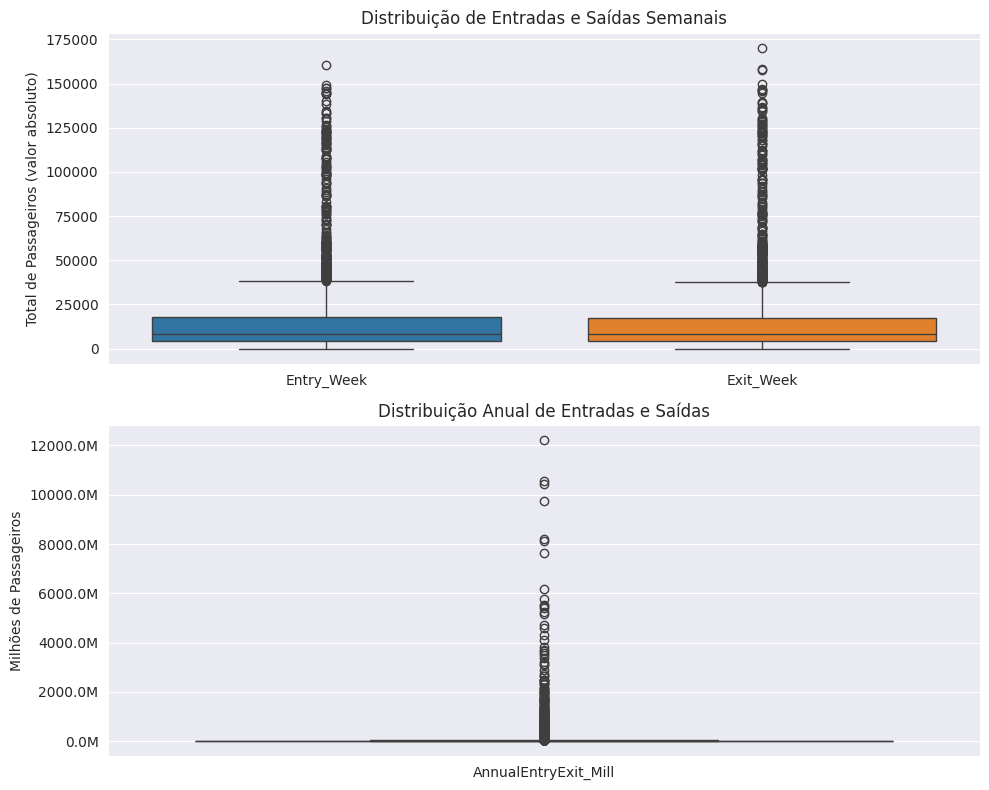

In [104]:
# Estilo
sns.set_style('darkgrid')

# Criar figura e subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Boxplot para Entry_Week e Exit_Week
sns.boxplot(data=full_df[['Entry_Week', 'Exit_Week']], ax=axes[0])
axes[0].set_title('Distribuição de Entradas e Saídas Semanais')
axes[0].set_ylabel('Total de Passageiros (valor absoluto)')

# Boxplot para AnnualEntryExit_Mill com escala formatada em milhões
sns.boxplot(data=full_df[['AnnualEntryExit_Mill']], ax=axes[1])
axes[1].set_title('Distribuição Anual de Entradas e Saídas')
axes[1].set_ylabel('Milhões de Passageiros')
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}M'))

# Ajustar layout
plt.tight_layout()

# Salvar imagem
plt.savefig('boxplots.pdf')
plt.show()

#### Análise dos boxplots

Os boxplots mostram a distribuição dos valores de movimento de passageiros nas estações do metrô de Londres em diferentes períodos:

##### 1. Boxplot Superior: Entradas e Saídas Semanais (Dias Úteis)
- **Eixo X**:
  - `Entry_Week`: Entradas em dias úteis
  - `Exit_Week`: Saídas em dias úteis
- **Eixo Y**: Total de passageiros (valores absolutos por dia), escala até 175.000 passageiros
- **Interpretação**:
  - Mostra a distribuição do número diário típico de passageiros em dias úteis
  - A mediana (linha no meio da caixa) parece estar em torno de 25.000-50.000 passageiros
  - Há vários outliers (pontos acima do bigode superior) indicando estações extremamente movimentadas

##### 2. Boxplot Inferior: Total Anual de Entradas e Saídas
- **Eixo X**: `AnnualEntryExit_Mill` (Total anual estimado em milhões)
- **Eixo Y**: Milhões de passageiros, escala até 12.000M (12 bilhões)
- **Interpretação**:
  - Mostra a distribuição do movimento anual estimado (soma de entradas e saídas)
  - A mediana parece estar abaixo de 2.000 milhões (2 bilhões)
  - Há outliers extremos chegando a 12.000 milhões (12 bilhões), o que provavelmente representa as estações mais movimentadas como King's Cross ou Waterloo

##### Grande variação entre estações - algumas têm movimento muito maior que outras
2. **Assimetria** nos dados - a maioria das estações tem valores moderados, mas poucas têm valores extremamente altos
3. **Padrão similar** entre entradas e saídas em dias úteis
4. **Escala anual** mostra o impacto cumulativo das estações mais movimentadas

Estes boxplots ajudam a visualizar a desigualdade no uso das estações, com poucas estações concentrando a maior parte do movimento de passageiros.

### Normalizando entradas/saídas

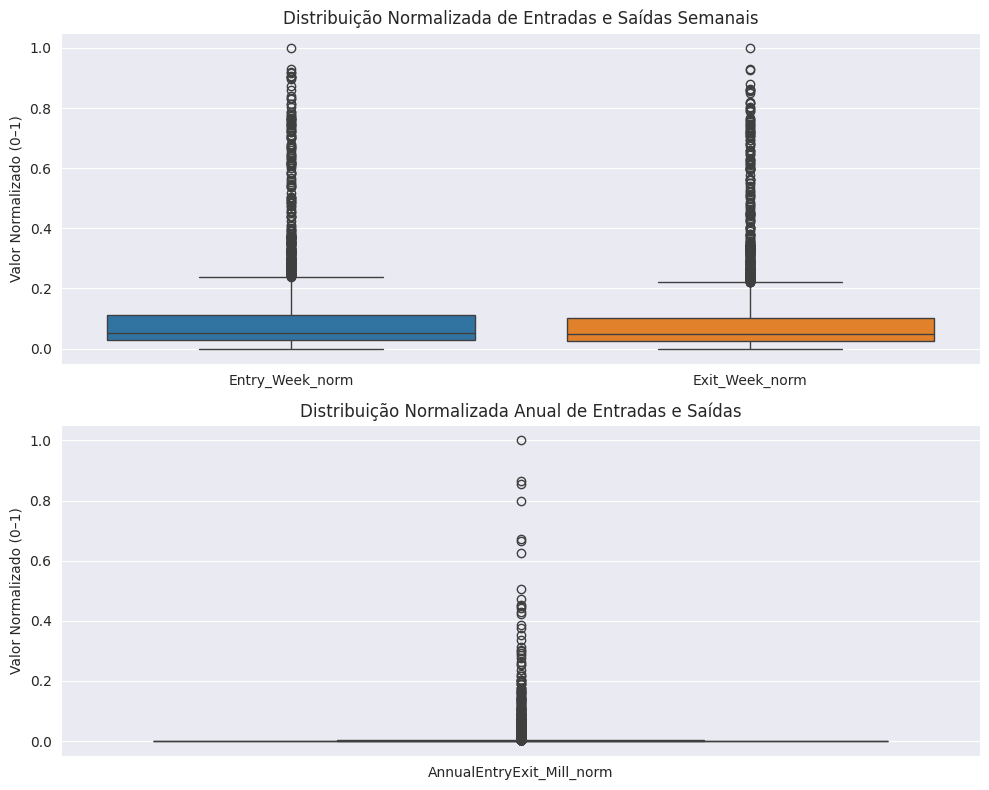

In [105]:
# Normalizar colunas selecionadas
scaler = MinMaxScaler()
cols_to_normalize = ['Entry_Week', 'Exit_Week', 'AnnualEntryExit_Mill']
normalized_data = scaler.fit_transform(full_df[cols_to_normalize])
normalized_df = pd.DataFrame(normalized_data, columns=[f'{col}_norm' for col in cols_to_normalize])

# Adicionar colunas normalizadas ao full_df
full_df = pd.concat([full_df, normalized_df], axis=1)

# Estilo
sns.set_style('darkgrid')

# Criar figura e subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Boxplot para entradas e saídas semanais normalizadas
sns.boxplot(data=full_df[['Entry_Week_norm', 'Exit_Week_norm']], ax=axes[0])
axes[0].set_title('Distribuição Normalizada de Entradas e Saídas Semanais')
axes[0].set_ylabel('Valor Normalizado (0–1)')

# Boxplot para total anual normalizado
sns.boxplot(data=full_df[['AnnualEntryExit_Mill_norm']], ax=axes[1])
axes[1].set_title('Distribuição Normalizada Anual de Entradas e Saídas')
axes[1].set_ylabel('Valor Normalizado (0–1)')

# Ajustar layout e salvar
plt.tight_layout()
plt.savefig('boxplots_normalizados.pdf')
plt.show()

A decisão de remover ou manter os outliers neste contexto requer uma análise cuidadosa dos seus objetivos com a GNN (Graph Neural Network). Vamos examinar os prós e contras:

### **Por que manter?**
1. **Representam a realidade operacional**:
   - Estações como King's Cross, Waterloo ou Victoria realmente têm fluxos muito superiores à média
   - Removê-los artificialmente equalizaria um sistema que é naturalmente assimétrico

2. **Impacto na topologia da rede**:
   - Esses hubs são nós críticos na rede de transporte
   - Sua remoção distorceria a representação de conectividade e fluxos de transferência

3. **Aprendizado robusto**:
   - Uma GNN exposta à distribuição real pode aprender padrões hierárquicos (hubs vs. estações periféricas)
   - Útil para aplicações como previsão de congestionamentos ou otimização de rotas

### **Argumentos para REMOVER/ATENUAR outliers**:
1. **Dominância no aprendizado**:
   - Valores extremos podem fazer a GNN "esquecer" padrões das estações medianas
   - Risco de o modelo se especializar apenas nos hubs principais

2. **Normalização alternativa**:
   - Transformações logarítmicas ou winsorization (ex.: limitar valores ao percentil 99) podem suavizar o impacto sem perder informação

3. **Cenários específicos**:
   - Se o foco for estações "comuns" (ex.: análise de bairros residenciais), a remoção pode ser justificável

### **Recomendações práticas**:
1. **Experimente ambas abordagens**:
   - Treine a GNN com e sem outliers e compare o desempenho

2. **Técnicas intermediárias**:
   - **Cap values**: Substituir valores acima do percentil 95 pela mediana do top 5%
   - **Embeddings separados**: Tratar hubs como uma categoria especial (ex.: adicionar feature binária "is_hub")

3. **Arquitetura adaptativa**:
   - Usar attention mechanisms para que a GNN aprenda a ponderar automaticamente nós com diferentes escalas

4. **Validação temática**:
   - Verifique se a remoção prejudica casos de uso reais (ex.: o modelo ainda consegue prever fluxos em estações turísticas?)

### **Exemplo de abordagem híbrida** (Python/pseudo-código):
```python
# Opção 1: Winsorization
from scipy.stats.mstats import winsorize
df['AnnualEntryExit_Mill'] = winsorize(df['AnnualEntryExit_Mill'], limits=[0.01, 0.01])

# Opção 2: Transformação logarítmica
df['log_annual'] = np.log1p(df['AnnualEntryExit_Mill'])

# Opção 3: Feature binária para hubs
df['is_hub'] = (df['AnnualEntryExit_Mill'] > threshold).astype(int)
```

### **Conclusão**:
Para capturar a "maior realidade possível", **manter os outliers é geralmente preferível**, mas com adaptações:
- Use normalização por quantis em vez de min-max
- Adicione mecanismos na arquitetura da GNN para lidar com a heterogeneidade (ex.: normalização de nós por grau)
- Considere camadas de atenção que automaticamente ajustem a importância relativa dos nós

A assimetria é uma característica intrínseca de redes de transporte, e uma GNN que a incorpore tende a gerar insights mais úteis para aplicações reais.

### Conversão de tipos e feature engineering

In [106]:
# Conversão para tipo categórico
full_df['nlc'] = full_df['nlc'].astype('category')
full_df['Station'] = full_df['Station'].astype('category')
full_df['Note'] = full_df['Note'].astype('category')

In [107]:
# Total de uso em dias de semana
full_df['Total_Weekday'] = full_df['Entry_Week'] + full_df['Exit_Week']

# Total de uso no fim de semana (sábado + domingo)
full_df['Total_Weekend'] = (
    full_df['Entry_Saturday'] + full_df['Exit_Saturday'] +
    full_df['Entry_Sunday'] + full_df['Exit_Sunday']
)

# Razão entre uso no fim de semana e nos dias úteis
full_df['Ratio_Weekend_Weekday'] = full_df['Total_Weekend'] / full_df['Total_Weekday']

In [108]:
full_df['date'].unique()

<PeriodArray>
['2011', '2010', '2008', '2013', '2012', '2007', '2009', '2014', '2016',
 '2017', '2015']
Length: 11, dtype: period[Y-DEC]

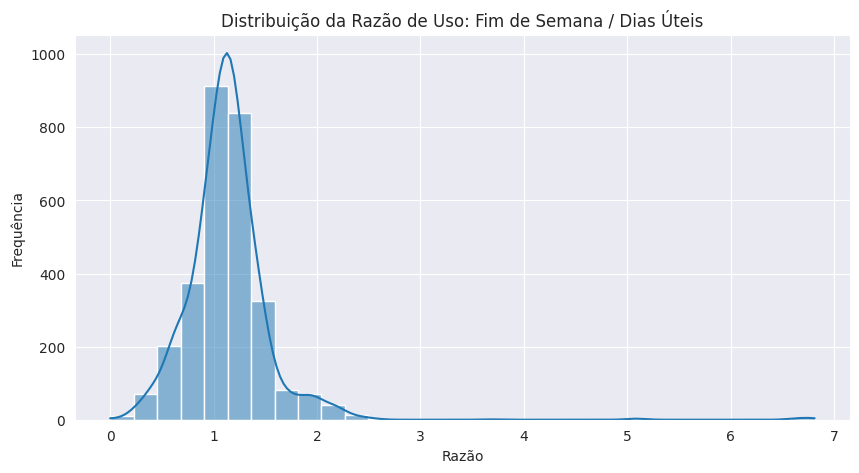

In [109]:
plt.figure(figsize=(10, 5))
sns.histplot(full_df['Ratio_Weekend_Weekday'], bins=30, kde=True)
plt.title('Distribuição da Razão de Uso: Fim de Semana / Dias Úteis')
plt.xlabel('Razão')
plt.ylabel('Frequência')
plt.show()

### Gráficos temporais agregando por ano

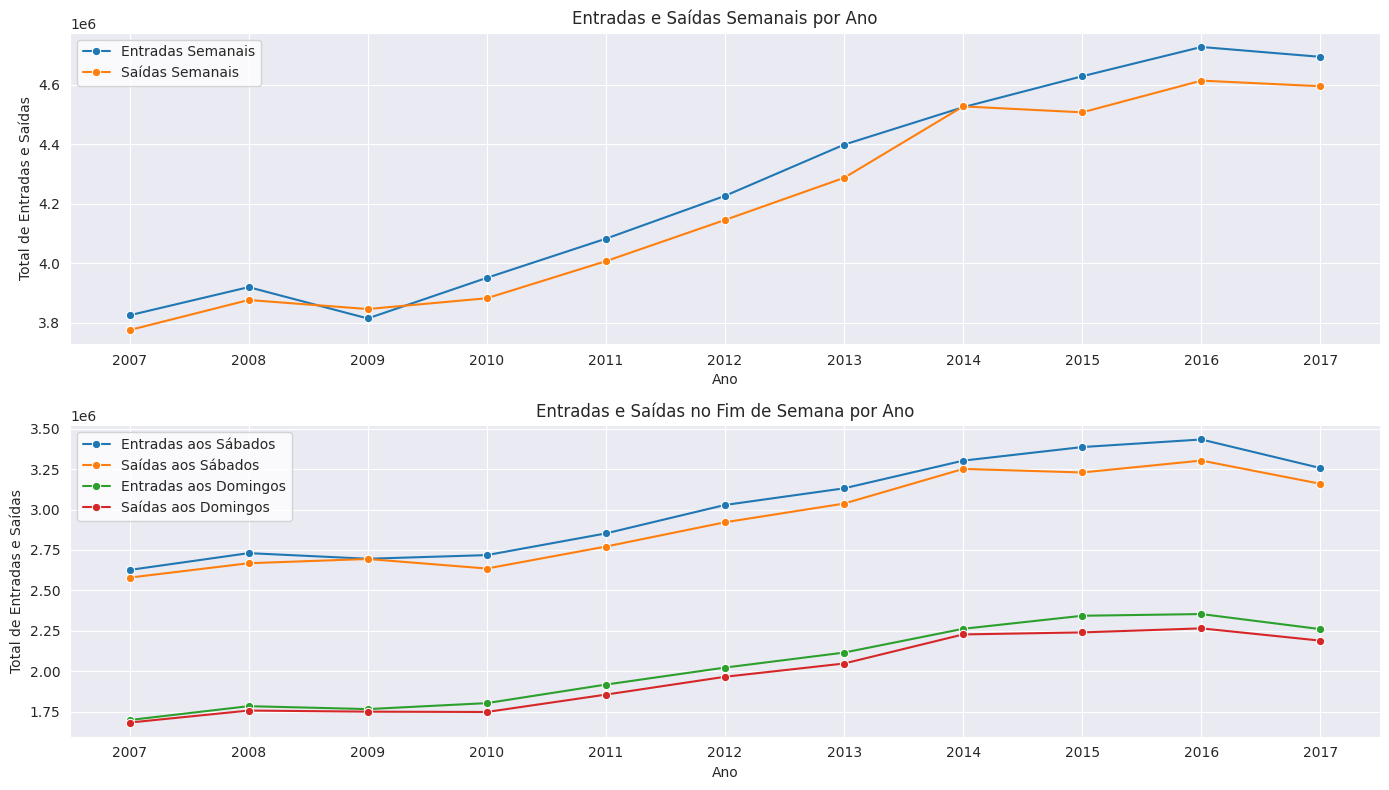

In [110]:
# Agregar os dados por ano (somando as entradas e saídas)
full_df['year'] = full_df['date'].dt.year

# Agregar por ano e somar as entradas e saídas
annual_data = full_df.groupby('year').agg({
    'Entry_Week': 'sum',
    'Entry_Saturday': 'sum',
    'Entry_Sunday': 'sum',
    'Exit_Week': 'sum',
    'Exit_Saturday': 'sum',
    'Exit_Sunday': 'sum',
    'AnnualEntryExit_Mill': 'sum'
}).reset_index()

# Estilo do gráfico
sns.set_style('darkgrid')

# Criar figura para os gráficos
plt.figure(figsize=(14, 8))

# Gráfico de Entradas e Saídas Semanais por Ano
plt.subplot(2, 1, 1)
sns.lineplot(data=annual_data, x='year', y='Entry_Week', label='Entradas Semanais', marker='o')
sns.lineplot(data=annual_data, x='year', y='Exit_Week', label='Saídas Semanais', marker='o')
plt.title('Entradas e Saídas Semanais por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Entradas e Saídas')
plt.legend(facecolor='white')

# Definindo os ticks do eixo X para 2007 a 2017
plt.xticks(ticks=range(2007, 2018))

# Gráfico de Entradas e Saídas Totais por Ano
plt.subplot(2, 1, 2)
sns.lineplot(data=annual_data, x='year', y='Entry_Saturday', label='Entradas aos Sábados', marker='o')
sns.lineplot(data=annual_data, x='year', y='Exit_Saturday', label='Saídas aos Sábados', marker='o')
sns.lineplot(data=annual_data, x='year', y='Entry_Sunday', label='Entradas aos Domingos', marker='o')
sns.lineplot(data=annual_data, x='year', y='Exit_Sunday', label='Saídas aos Domingos', marker='o')
plt.title('Entradas e Saídas no Fim de Semana por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Entradas e Saídas')
plt.legend(facecolor='white')

# Definindo os ticks do eixo X para 2007 a 2017
plt.xticks(ticks=range(2007, 2018))

# Exibir os gráficos
plt.tight_layout()
plt.show()

## Futuro: incluir dados geográficos + grafo

In [111]:
!wget -O LB_MSOA2021_shp.zip https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/LB_MSOA2021_shp.zip

--2025-06-01 16:53:53--  https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/LB_MSOA2021_shp.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/LB_MSOA2021_shp.zip [following]
--2025-06-01 16:53:53--  https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/LB_MSOA2021_shp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960034 (8.5M) [application/zip]
Saving to: ‘LB_MSOA2021_shp.zip’

LB_MSOA2021_shp.zip 100%[===================>]   8.54M  --.-KB/s    in 0.04s   

2025-06-01 16:53:54 (198 MB/s) - ‘L

In [112]:
# Caminho para o arquivo ZIP
zip_path = '/content/LB_MSOA2021_shp.zip'

# Abre o arquivo ZIP e extrai tudo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print(f"Arquivos extraídos...")

Arquivos extraídos...


In [113]:
# Caminho do arquivo JSON
stations_file = path + "/stations.json"

# Carregar o JSON
with open(stations_file, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extração dos dados das estações
stations = data.get("stations", {})

# Transformar os dados no formato adequado para um DataFrame
stations_list = []
for station_id, details in stations.items():
    if "position" in details:
        stations_list.append({
            "station_id": station_id,
            "title": details.get("title", ""),
            "text": details.get("text", ""),
            "lat": details["position"]["lat"],
            "lon": details["position"]["lon"],
            "zone": details.get("zone", None)
        })

station_df = pd.DataFrame(stations_list)

In [114]:
station_df

,station_id,title,text,lat,lon,zone
0,ActonTown,Acton Town,Acton \nTown,51.502500,-0.278126,3
1,Aldgate,Aldgate,Aldgate,51.513940,-0.075370,1
2,AldgateEast,Aldgate East,Aldgate \nEast,51.515140,-0.071780,1
3,Alperton,Alperton,Alperton,51.540970,-0.300610,4
4,Amersham,Amersham,Amersham,51.674350,-0.607320,9
...,...,...,...,...,...,...
261,WimbledonPark,Wimbledon Park,Wimbledon Park,51.433910,-0.198640,3
262,WoodGreen,Wood Green,Wood Green,51.597090,-0.109390,3
263,WoodLane,Wood Lane,Wood \nLane,51.597090,-0.109390,2
264,Woodford,Woodford,Woodford,51.605820,0.033280,4


In [115]:
# Fuzzy matching entre nomes de estação
unique_stations = full_df['Station'].unique()
json_titles = station_df['title'].tolist()

matches = []
for station in unique_stations:
    best_match, score = process.extractOne(station, json_titles)
    matches.append({
        "Station": station,
        "matched_title": best_match,
        "match_score": score
    })

matches_df = pd.DataFrame(matches)

# Agora juntar lat, lon e zone usando matched_title (do JSON)
matches_with_info = matches_df.merge(
    station_df[['title', 'lat', 'lon', 'zone']],
    left_on='matched_title', right_on='title',
    how='left'
)

# Juntar isso ao full_df usando o nome original da estação
full_df_with_zone = full_df.merge(
    matches_with_info[['Station', 'lat', 'lon', 'zone']],
    on='Station',
    how='left'
)

# Criar geometria com lat/lon
geometry = [Point(xy) for xy in zip(full_df_with_zone['lon'], full_df_with_zone['lat'])]

# Criar GeoDataFrame final com a nova coluna zone incluída
full_gdf_final = gpd.GeoDataFrame(full_df_with_zone, geometry=geometry, crs='EPSG:4326')

# Verificar resultado
print(full_gdf_final[['Station', 'lat', 'lon', 'zone', 'geometry']].head())

                               Station       lat       lon  zone  \
0  Acton Town                           51.50250 -0.278126     3   
1  Aldgate                              51.51394 -0.075370     1   
2  Aldgate East                         51.51514 -0.071780     1   
3  Alperton                             51.54097 -0.300610     4   
4  Amersham                             51.67435 -0.607320     9   

                    geometry  
0   POINT (-0.27813 51.5025)  
1  POINT (-0.07537 51.51394)  
2  POINT (-0.07178 51.51514)  
3  POINT (-0.30061 51.54097)  
4  POINT (-0.60732 51.67435)  


In [116]:
matches_df

,Station,matched_title,match_score
0,Acton Town,Acton Town,100
1,Aldgate,Aldgate,100
2,Aldgate East,Aldgate East,100
3,Alperton,Alperton,100
4,Amersham,Amersham,100
...,...,...,...
879,West Kensington,West Kensington,100
880,Westbourne Park,Westbourne Park,100
881,Willesden Green,Willesden Green,100
882,Willesden Junction,Willesden Junction,100


In [117]:
full_gdf_final

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,...,Exit_Week_norm,AnnualEntryExit_Mill_norm,Total_Weekday,Total_Weekend,Ratio_Weekend_Weekday,year,lat,lon,zone,geometry
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,...,0.049305,0.000447,17094.0,20741.0,1.213350,2011,51.502500,-0.278126,3,POINT (-0.27813 51.5025)
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,...,0.064152,0.000511,22238.0,11043.0,0.496582,2011,51.513940,-0.075370,1,POINT (-0.07537 51.51394)
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,...,0.082001,0.000750,29002.0,32883.0,1.133818,2011,51.515140,-0.071780,1,POINT (-0.07178 51.51514)
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,...,0.027408,0.000242,9143.0,11513.0,1.259215,2011,51.540970,-0.300610,4,POINT (-0.30061 51.54097)
4,506,Amersham,,3461.0,1496.0,975.0,3775.0,1582.0,869.0,2.100000,...,0.022179,0.000172,7236.0,4922.0,0.680210,2011,51.674350,-0.607320,9,POINT (-0.60732 51.67435)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,...,0.014876,0.000149,5825.0,6345.0,1.089270,2015,51.433910,-0.198640,3,POINT (-0.19864 51.43391)
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,...,0.111524,0.001080,39263.0,59325.0,1.510965,2015,51.597090,-0.109390,3,POINT (-0.10939 51.59709)
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,...,0.035704,0.000303,11534.0,14355.0,1.244581,2015,51.597090,-0.109390,2,POINT (-0.10939 51.59709)
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,...,0.055703,0.000494,19118.0,21887.0,1.144837,2015,51.605820,0.033280,4,POINT (0.03328 51.60582)


In [118]:
# Caminho para a pasta onde estão os arquivos
folder_path = "/content/msoa2021"

# Lista de todos os arquivos .shp
shp_files = [f for f in os.listdir(folder_path) if f.endswith(".shp")]

# Lista para armazenar os GeoDataFrames
gdfs = []

# Ler todos os .shp e armazenar na lista
for shp_file in shp_files:
    full_path = os.path.join(folder_path, shp_file)
    try:
        gdf = gpd.read_file(full_path)
        gdfs.append(gdf)
    except Exception as e:
        print(f"Erro ao ler {shp_file}: {e}")

# Combinar todos os mapas num único GeoDataFrame
map_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Garantir que o CRS dos pontos (gdf/full_gdf_final) está no mesmo CRS do mapa
if gdf.crs != map_gdf.crs:
    gdf = gdf.to_crs(map_gdf.crs)
    full_gdf_final = full_gdf_final.to_crs(map_gdf.crs)

#  Garantir que CRS seja o mesmo
if full_gdf_final.crs != map_gdf.crs:
    full_gdf_final = full_gdf_final.to_crs(map_gdf.crs)

# 2. Unir geometria do mapa com método atualizado
map_union = map_gdf.union_all()

# 3. Filtrar apenas estações dentro do mapa
stations_within_map = full_gdf_final[full_gdf_final.geometry.within(map_union)]

In [119]:
full_gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype        
---  ------                     --------------  -----        
 0   nlc                        2955 non-null   category     
 1   Station                    2955 non-null   object       
 2   Note                       2955 non-null   category     
 3   Entry_Week                 2955 non-null   float64      
 4   Entry_Saturday             2955 non-null   float64      
 5   Entry_Sunday               2955 non-null   float64      
 6   Exit_Week                  2955 non-null   float64      
 7   Exit_Saturday              2955 non-null   float64      
 8   Exit_Sunday                2955 non-null   float64      
 9   AnnualEntryExit_Mill       2955 non-null   float64      
 10  date                       2955 non-null   period[Y-DEC]
 11  Borough                    1072 non-null   object       
 12  Entry_Week_n

In [120]:
# Spatial join: associar cada estação ao distrito (bairro)
stations_with_msoa = gpd.sjoin(
    full_gdf_final, map_gdf, how="left", predicate="within"
)

# Preencher a coluna 'Borough' com base em 'lad22nm'
stations_with_msoa['Borough_inferred'] = stations_with_msoa['lad22nm']
stations_with_msoa['Borough'] = stations_with_msoa['Borough'].fillna(stations_with_msoa['Borough_inferred'])

# Limpar colunas temporárias
full_gdf_final = stations_with_msoa.drop(columns=['index_right', 'Borough_inferred'])

# Verificar quantos ainda ficaram nulos
print(full_gdf_final['Borough'].isna().sum())

135


In [121]:
full_gdf_final['Borough'].isna().sum()

np.int64(135)

# Fase 2 - Mineração de padrões frequentes

# Construindo o grafo de fato

In [122]:
!wget -O "London_Train_Lines.json" "https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/London%20Train%20Lines.json"
!wget -O "London_Stations.json" "https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/London%20stations.json"

--2025-06-01 16:54:18--  https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/London%20Train%20Lines.json
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/London%20Train%20Lines.json [following]
--2025-06-01 16:54:18--  https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/London%20Train%20Lines.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 682792 (667K) [text/plain]
Saving to: ‘London_Train_Lines.json’

London_Train_Lines. 100%[===================>] 666.79K  --.-KB/s    in 0.006s  

2025-06-01 16

In [123]:
# Linhas de trem/metrô
rail_lines_gdf = gpd.read_file("/content/London_Train_Lines.json")

# Estações
stations_gdf = gpd.read_file("/content/London_Stations.json")

print(rail_lines_gdf.head())
print(stations_gdf.head())

print(55 * '-')

print(rail_lines_gdf.crs)
print(stations_gdf.crs)

print(55 * '-')

print(rail_lines_gdf.info())
print(stations_gdf.info())

                                               name   stroke  stroke-width  \
0           Bakerloo - Baker Street to Regents Park  #ae6118             7   
1            Bakerloo - Charing Cross to Embankment  #ae6118             7   
2  Bakerloo - Edgware Road (Bakerloo) to Marylebone  #ae6118             7   
3                 Bakerloo - Embankment to Waterloo  #ae6118             7   
4        Bakerloo - Harlesden to Willesden Junction  #ae6118             7   

                                            geometry  
0   LINESTRING (-0.1569 51.52313, -0.14534 51.52381)  
1   LINESTRING (-0.1248 51.50836, -0.12237 51.50731)  
2   LINESTRING (-0.17054 51.52065, -0.16349 51.5224)  
3  LINESTRING (-0.12237 51.50731, -0.11326 51.50315)  
4   LINESTRING (-0.2575 51.53626, -0.24391 51.53223)  
                                                link             name  \
0  https://www.doogal.co.uk/StationMap?station=Ab...       Abbey Road   
1  https://www.doogal.co.uk/StationMap?station=Ab...   

In [124]:
stations_gdf['zone'].unique()

array(['3', '4', '2', '3,4,5,6', '5', '1', '9', '2,3', '6', '3,4', '',
       '8', '7', '1,2', '5,6', '6,7'], dtype=object)

In [125]:
stations_gdf

,link,name,marker-color,zone,postcode,geometry
0,https://www.doogal.co.uk/StationMap?station=Ab...,Abbey Road,yellow,3,E15 3NB,POINT (0.00372 51.53195)
1,https://www.doogal.co.uk/StationMap?station=Ab...,Abbey Wood,GreenYellow,4,SE2 9RH,POINT (0.12027 51.49078)
2,https://www.doogal.co.uk/StationMap?station=Ac...,Acton Central,orange,2,W3 6BH,POINT (-0.26343 51.50876)
3,https://www.doogal.co.uk/StationMap?station=Ac...,Acton Main Line,yellow,3,W3 9EH,POINT (-0.26769 51.51689)
4,https://www.doogal.co.uk/StationMap?station=Ac...,Acton Town,yellow,3,W3 8HN,POINT (-0.2803 51.50307)
...,...,...,...,...,...,...
654,https://www.doogal.co.uk/StationMap?station=Wo...,Woodside Park,GreenYellow,4,N12 8SE,POINT (-0.18543 51.61787)
655,https://www.doogal.co.uk/StationMap?station=Wo...,Woolwich,GreenYellow,4,SE18 6EU,POINT (0.07182 51.49158)
656,https://www.doogal.co.uk/StationMap?station=Wo...,Woolwich Arsenal,GreenYellow,4,SE18 6HX,POINT (0.06919 51.48991)
657,https://www.doogal.co.uk/StationMap?station=Wo...,Woolwich Dockyard,yellow,3,SE18 5JY,POINT (0.05461 51.49111)


## Apenas visualização ESPACIAL

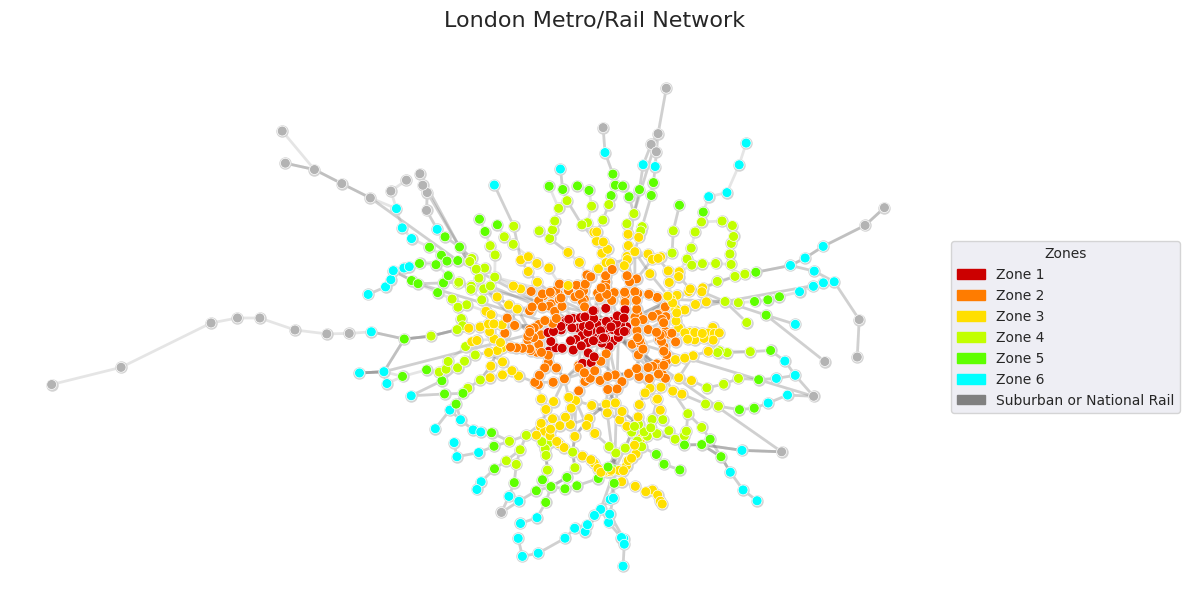

In [126]:
# Fixed color dictionary for zones 1 to 6
zone_colors = {
    1: "#cc0000",  # Zone 1 - red
    2: "#ff7c00",  # Zone 2 - orange
    3: "#ffdf00",  # Zone 3 - yellow
    4: "#c2ff00",  # Zone 4 - light green
    5: "#5eff00",  # Zone 5 - strong green
    6: "#00ffff",  # Zone 6 - cyan
}

# Function to decide station color based on zone
def fixed_zone_color(zone_str):
    if not isinstance(zone_str, str) or zone_str.strip() == '':
        return (0.7, 0.7, 0.7)  # gray for empty or invalid
    zones = [int(z.strip()) for z in zone_str.split(',') if z.strip().isdigit()]
    valid_zones = [z for z in zones if z in zone_colors]
    if valid_zones:
        return to_rgb(zone_colors[valid_zones[0]])  # take the first valid
    return (0.7, 0.7, 0.7)  # gray for zones > 6 or invalid

# Apply color to each station
stations_gdf['color'] = stations_gdf['zone'].astype(str).apply(fixed_zone_color)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot rail lines
rail_lines_gdf.plot(ax=ax, linewidth=2, edgecolor="gray", alpha=0.2, zorder=1)

# Optional: background halo layer to improve node visibility
stations_gdf.plot(ax=ax, color='lightgray', markersize=80, linewidth=0, zorder=2)

# Plot stations with colored nodes and white borders
stations_gdf.plot(
    ax=ax,
    color=stations_gdf['color'],
    markersize=50,
    edgecolor='white',
    linewidth=0.5,
    zorder=3
)

# Create custom legend
legend_patches = [mpatches.Patch(color=zone_colors[z], label=f"Zone {z}") for z in range(1, 7)]
legend_patches.append(mpatches.Patch(color='gray', label='Suburban or National Rail'))

# Add figure-level title centered above the entire plot area
fig.suptitle("London Metro/Rail Network", fontsize=16, y=0.75)
legend = ax.legend(
    handles=legend_patches,
    title="Zones",
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),  # position to the far right and centered vertically
    frameon=True
)

ax.set_axis_off()
plt.tight_layout()
plt.savefig('london_metro_rail_net.pdf')
plt.show()

## Alocando em um objeto NetworkX

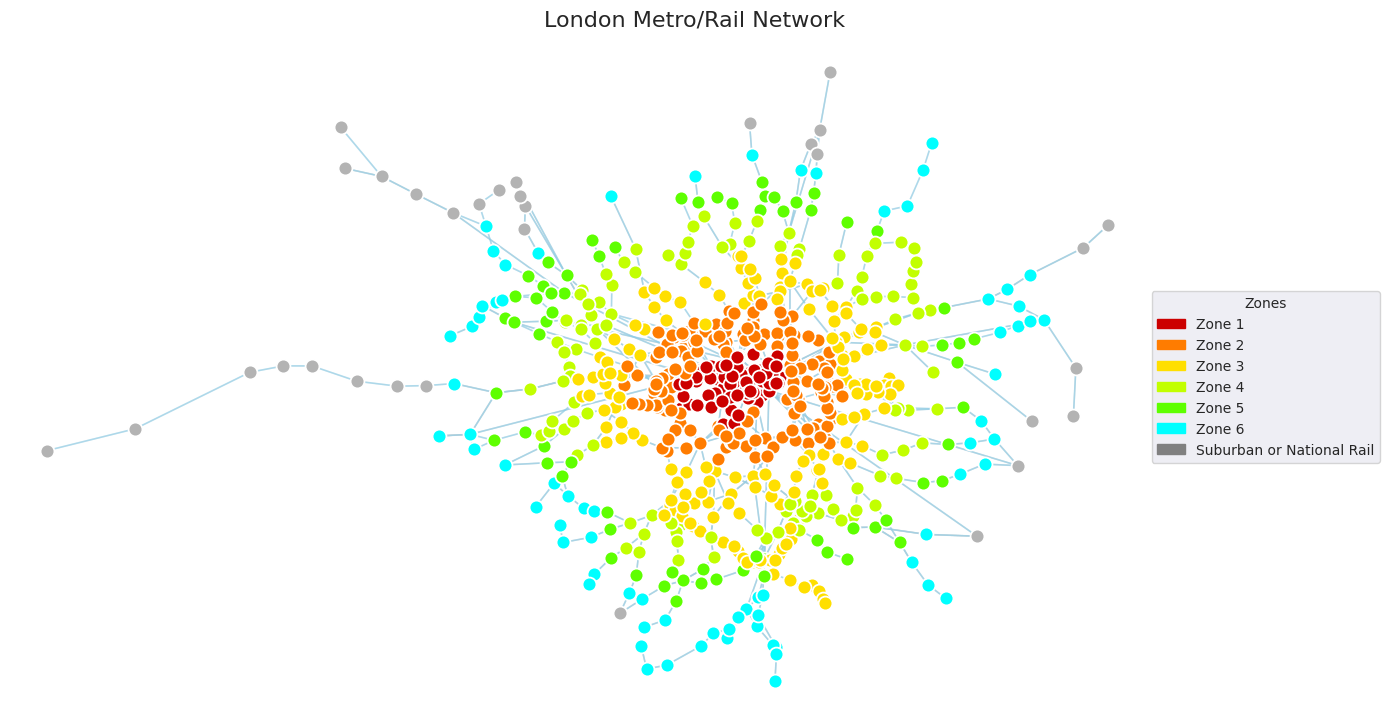

In [147]:
# Carregar os dados
rail_lines_gdf = gpd.read_file("London_Train_Lines.json")
stations_gdf = gpd.read_file("London_Stations.json")

# Reprojetar para CRS métrico (metros) e copiar para evitar warning
stations_proj = stations_gdf.to_crs(epsg=3857).copy()
rail_lines_proj = rail_lines_gdf.to_crs(epsg=3857)

# Definir dicionário de cores por zona
zone_colors = {
    1: "#cc0000",
    2: "#ff7c00",
    3: "#ffdf00",
    4: "#c2ff00",
    5: "#5eff00",
    6: "#00ffff"
}

def fixed_zone_color(zone_str):
    if not isinstance(zone_str, str) or zone_str.strip() == '':
        return (0.7, 0.7, 0.7)
    zones = [int(z.strip()) for z in zone_str.split(',') if z.strip().isdigit()]
    valid_zones = [z for z in zones if z in zone_colors]
    if valid_zones:
        return to_rgb(zone_colors[valid_zones[0]])
    return (0.7, 0.7, 0.7)

# Atribuir cores com .loc para evitar SettingWithCopyWarning
stations_proj.loc[:, 'color'] = stations_proj['zone'].astype(str).apply(fixed_zone_color)

# Construir grafo
G = nx.Graph()
for idx, row in stations_proj.iterrows():
    G.add_node(row['name'], geometry=row.geometry, zone=row['zone'], color=row['color'])

# Criar arestas com base na proximidade às linhas
for line in rail_lines_proj.geometry:
    buffer = line.buffer(100)  # 100 metros
    nearby = stations_proj[stations_proj.geometry.intersects(buffer)].copy()
    nearby.loc[:, 'dist_along'] = nearby.geometry.apply(lambda p: line.project(p))
    nearby_sorted = nearby.sort_values(by='dist_along')
    names = nearby_sorted['name'].tolist()
    for i in range(len(names) - 1):
        if not G.has_edge(names[i], names[i + 1]):
            G.add_edge(names[i], names[i + 1])

fig, ax = plt.subplots(figsize=(14, 14))  # maior figura para mais detalhe

# Fundo com linhas ferroviárias
rail_lines_proj.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5, zorder=0)

# Arestas (linhas entre estações)
for u, v in G.edges():
    p1 = G.nodes[u]['geometry']
    p2 = G.nodes[v]['geometry']
    line = LineString([p1, p2])
    ax.plot(*line.xy, color="skyblue", linewidth=1.2, alpha=0.6, zorder=1)

# Nós (estações)
for node, data in G.nodes(data=True):
    ax.plot(data['geometry'].x, data['geometry'].y, 'o',
            markersize=10,  # AUMENTADO
            color=data['color'],
            markeredgecolor='white',
            markeredgewidth=1.3,
            zorder=2)

# Legenda
legend_patches = [mpatches.Patch(color=zone_colors[z], label=f"Zone {z}") for z in zone_colors]
legend_patches.append(mpatches.Patch(color='gray', label='Suburban or National Rail'))
ax.legend(handles=legend_patches, title="Zones", loc='center left', bbox_to_anchor=(1, 0.5))

# Título e ajustes
fig.suptitle("London Metro/Rail Network", fontsize=16, y=0.75)
ax.set_axis_off()
plt.tight_layout()

# ZOOM MANUAL (opcional)
minx, miny, maxx, maxy = stations_proj.total_bounds
ax.set_xlim(minx - 5000, maxx + 5000)
ax.set_ylim(miny - 5000, maxy + 5000)

plt.show()

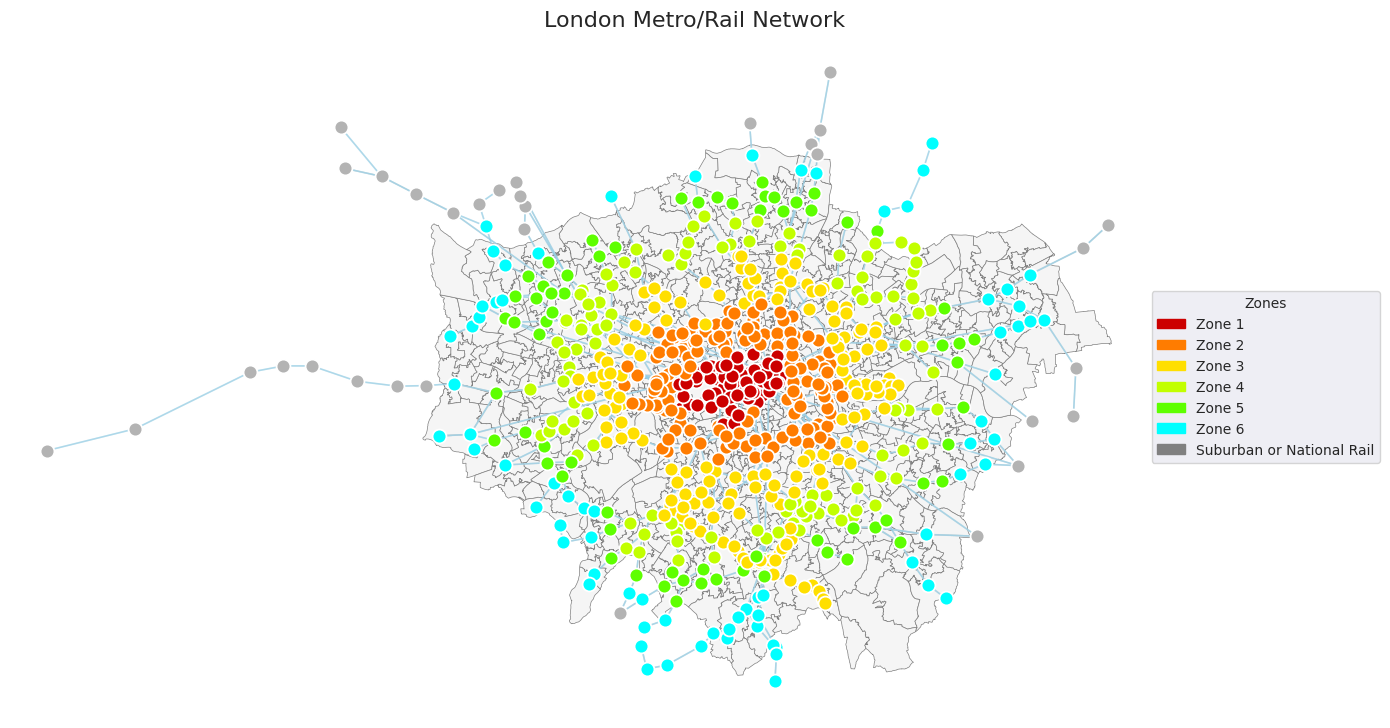

In [148]:
# Reprojetar map_gdf para EPSG:3857 se necessário
if map_gdf.crs != "EPSG:3857":
    map_gdf = map_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(14, 14))

# Fundo do mapa
map_gdf.plot(ax=ax, color="whitesmoke", edgecolor="gray", linewidth=0.5, zorder=0)

# Linhas ferroviárias
rail_lines_proj.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5, zorder=1)

# Arestas (conexões entre estações)
for u, v in G.edges():
    p1 = G.nodes[u]['geometry']
    p2 = G.nodes[v]['geometry']
    line = LineString([p1, p2])
    ax.plot(*line.xy, color="skyblue", linewidth=1.2, alpha=0.6, zorder=2)

# Nós (estações)
for node, data in G.nodes(data=True):
    ax.plot(data['geometry'].x, data['geometry'].y, 'o',
            markersize=10,
            color=data['color'],
            markeredgecolor='white',
            markeredgewidth=1.3,
            zorder=3)

# Legenda
legend_patches = [mpatches.Patch(color=zone_colors[z], label=f"Zone {z}") for z in zone_colors]
legend_patches.append(mpatches.Patch(color='gray', label='Suburban or National Rail'))
ax.legend(handles=legend_patches, title="Zones", loc='center left', bbox_to_anchor=(1, 0.5))

# Título e ajustes
fig.suptitle("London Metro/Rail Network", fontsize=16, y=0.75)
ax.set_axis_off()
plt.tight_layout()

# Zoom manual (opcional)
minx, miny, maxx, maxy = stations_proj.total_bounds
ax.set_xlim(minx - 5000, maxx + 5000)
ax.set_ylim(miny - 5000, maxy + 5000)

plt.show()

In [129]:
G

In [130]:
len(G.edges())

831

In [131]:
k=0
for node, data in G.nodes(data=True):
    print(f"Nó: {node}")
    k+=1
    if k == 4:
      break
    for key, value in data.items():
        print(f"  {key}: {value}")
    print("-" * 40)

Nó: Abbey Road
  geometry: POINT (414.483774701194 6715934.816249531)
  zone: 3
  color: (1.0, 0.8745098039215686, 0.0)
----------------------------------------
Nó: Abbey Wood
  geometry: POINT (13388.61452842085 6708571.276445808)
  zone: 4
  color: (0.7607843137254902, 1.0, 0.0)
----------------------------------------
Nó: Acton Central
  geometry: POINT (-29324.91520322829 6711785.2432781495)
  zone: 2
  color: (1.0, 0.48627450980392156, 0.0)
----------------------------------------
Nó: Acton Main Line


In [132]:
with open("london_metro_graph.pkl", "wb") as f:
    pk.dump(G, f)

# Fase 2 - Descrição do GeoDataFrame resultante da Fase 1

Este `GeoDataFrame` contém **2737 entradas** e **26 colunas**, representando informações espaciais e temporais sobre estações, fluxo de passageiros e dados geográficos no contexto urbano.

## Estrutura

* **Tipo:** `GeoDataFrame`
* **Entradas:** 2737
* **Colunas:** 26

---

## Colunas

| Coluna                       | Descrição                                                                 | Tipo            |
|-----------------------------|---------------------------------------------------------------------------|-----------------|
| **nlc**                     | ID da estação (código numérico)                                          | `object`        |
| **Station Name**            | Nome da estação                                                          | `object`        |
| **Borough**                 | Nome do bairro ou região onde a estação está localizada                  | `object`        |
| **Note**                    | Observações sobre a contagem de dados                                    | `object`        |
| **Entry_Week**              | Total típico de entradas em um dia útil                                  | `float64`       |
| **Entry_Saturday**          | Total típico de entradas em um sábado                                    | `float64`       |
| **Entry_Sunday**            | Total típico de entradas em um domingo                                   | `float64`       |
| **Exit_Week**               | Total típico de saídas em um dia útil                                    | `float64`       |
| **Exit_Saturday**           | Total típico de saídas em um sábado                                      | `float64`       |
| **Exit_Sunday**             | Total típico de saídas em um domingo                                     | `float64`       |
| **AnnualEntryExit_Mill**    | Total anual estimado de entradas + saídas (em milhões)                   | `float64`       |
| **date**                    | Ano da contagem (em formato de período anual)                            | `period[Y-DEC]` |
| **Entry_Week_norm**         | Entrada em dia útil, normalizada (escala comparativa entre estações)     | `float64`       |
| **Exit_Week_norm**          | Saída em dia útil, normalizada                                           | `float64`       |
| **AnnualEntryExit_Mill_norm** | Total anual de fluxo, normalizado                                      | `float64`       |
| **Total_Weekday**           | Soma de entradas e saídas em dias úteis                                  | `float64`       |
| **Total_Weekend**           | Soma de entradas e saídas no fim de semana                               | `float64`       |
| **Ratio_Weekend_Weekday**   | Razão entre o fluxo de fim de semana e dias úteis                        | `float64`       |
| **year**                    | Ano extraído da coluna `date`                                            | `int64`         |
| **lat**                     | Latitude da estação                                                      | `float64`       |
| **lon**                     | Longitude da estação                                                     | `float64`       |
| **geometry**                | Geometria do ponto geográfico (latitude, longitude)                      | `geometry`      |
| **msoa21cd**                | Código da área estatística (MSOA 2021)                                   | `object`        |
| **msoa21nm**                | Nome da área estatística (MSOA 2021)                                     | `object`        |
| **lad22cd**                 | Código do distrito administrativo local (LAD 2022)                       | `object`        |
| **lad22nm**                 | Nome do distrito administrativo local (LAD 2022)                         | `object`        |

---

## Notas

* A presença da coluna `geometry` torna esse objeto um `GeoDataFrame`, permitindo operações espaciais com bibliotecas como `GeoPandas`.
* As colunas `lat` e `lon` também estão disponíveis para uso direto sem depender de `geometry`.
* As colunas normalizadas (`_norm`) são úteis para comparações relativas entre estações, independente da escala absoluta.
* MSOA é uma unidade geográfica de nível médio, utilizada no recenseamento populacional da Inglaterra e País de Gales, com uma população típica de 7.000-10.000 pessoas. É construída a partir de aglomerados de "Lower Layer Super Output Areas" (LSOA).

In [133]:
# Remove todas as linhas com pelo menos um valor NaN
full_gdf_final = full_gdf_final.dropna()
full_gdf_final.reset_index()
full_gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2737 entries, 0 to 2954
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype        
---  ------                     --------------  -----        
 0   nlc                        2737 non-null   category     
 1   Station                    2737 non-null   object       
 2   Note                       2737 non-null   category     
 3   Entry_Week                 2737 non-null   float64      
 4   Entry_Saturday             2737 non-null   float64      
 5   Entry_Sunday               2737 non-null   float64      
 6   Exit_Week                  2737 non-null   float64      
 7   Exit_Saturday              2737 non-null   float64      
 8   Exit_Sunday                2737 non-null   float64      
 9   AnnualEntryExit_Mill       2737 non-null   float64      
 10  date                       2737 non-null   period[Y-DEC]
 11  Borough                    2737 non-null   object       
 12  Entry_Week_norm  

In [134]:
full_gdf_final

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,...,Ratio_Weekend_Weekday,year,lat,lon,zone,geometry,msoa21cd,msoa21nm,lad22cd,lad22nm
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,...,1.213350,2011,51.502500,-0.278126,3,POINT (519609.561 179579.054),E02000270,Ealing 033,E09000009,Ealing
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,...,0.496582,2011,51.513940,-0.075370,1,POINT (533648 181201.736),E02000001,City of London 001,E09000001,City of London
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,...,1.133818,2011,51.515140,-0.071780,1,POINT (533893.575 181341.736),E02000884,Tower Hamlets 021,E09000030,Tower Hamlets
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,...,1.259215,2011,51.540970,-0.300610,4,POINT (517949.734 183820.682),E02000121,Brent 029,E09000005,Brent
5,507,Angel,,27812.0,21215.0,12655.0,27740.0,21851.0,12446.0,17.780000,...,1.227085,2011,51.532530,-0.105790,1,POINT (531483.794 183213.935),E02000573,Islington 020,E09000019,Islington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,...,1.089270,2015,51.433910,-0.198640,3,POINT (525313.801 172084.357),E02000689,Merton 001,E09000024,Merton
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,...,1.510965,2015,51.597090,-0.109390,3,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,...,1.244581,2015,51.597090,-0.109390,2,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,...,1.144837,2015,51.605820,0.033280,4,POINT (540902.528 191622.832),E02000751,Redbridge 001,E09000026,Redbridge


## 1) Discretizar atributos numéricos

In [135]:
# Cópia da base para transformar
df_assoc = full_gdf_final.copy()

# Discretizar as colunas alvo em 3 categorias (low, medium, high)
df_assoc['Total_Weekday_bin'] = pd.qcut(df_assoc['Total_Weekday'], q=3, labels=['low', 'medium', 'high'])
df_assoc['Total_Weekend_bin'] = pd.qcut(df_assoc['Total_Weekend'], q=3, labels=['low', 'medium', 'high'])

In [136]:
'Anerley' in df_assoc['Station'].values

False

In [137]:
df_assoc

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,...,lat,lon,zone,geometry,msoa21cd,msoa21nm,lad22cd,lad22nm,Total_Weekday_bin,Total_Weekend_bin
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,...,51.502500,-0.278126,3,POINT (519609.561 179579.054),E02000270,Ealing 033,E09000009,Ealing,medium,medium
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,...,51.513940,-0.075370,1,POINT (533648 181201.736),E02000001,City of London 001,E09000001,City of London,medium,low
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,...,51.515140,-0.071780,1,POINT (533893.575 181341.736),E02000884,Tower Hamlets 021,E09000030,Tower Hamlets,high,high
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,...,51.540970,-0.300610,4,POINT (517949.734 183820.682),E02000121,Brent 029,E09000005,Brent,low,low
5,507,Angel,,27812.0,21215.0,12655.0,27740.0,21851.0,12446.0,17.780000,...,51.532530,-0.105790,1,POINT (531483.794 183213.935),E02000573,Islington 020,E09000019,Islington,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,...,51.433910,-0.198640,3,POINT (525313.801 172084.357),E02000689,Merton 001,E09000024,Merton,low,low
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,...,51.597090,-0.109390,3,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey,high,high
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,...,51.597090,-0.109390,2,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey,low,medium
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,...,51.605820,0.033280,4,POINT (540902.528 191622.832),E02000751,Redbridge 001,E09000026,Redbridge,medium,medium


In [138]:
# Discretizar também a razão entre finais de semana e dias úteis
df_assoc['Ratio_bin'] = pd.qcut(df_assoc['Ratio_Weekend_Weekday'], q=3, labels=['low', 'medium', 'high'])

# Colunas categóricas úteis diretamente
cat_cols = ['Borough', 'zone']
for col in cat_cols:
    df_assoc[col] = df_assoc[col].astype(str)

## 2) Transformar para formato transacional

In [139]:
# Montar transações estilo "col=valor"
trans_cols = ['Total_Weekday_bin', 'Total_Weekend_bin', 'Ratio_bin', 'Borough', 'zone']

transactions = []
for _, row in df_assoc[trans_cols].iterrows():
    items = [f"{col}={row[col]}" for col in trans_cols]
    transactions.append(items)

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

In [140]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Borough=Barking and Dagenham    2737 non-null   bool 
 1   Borough=Barnet                  2737 non-null   bool 
 2   Borough=Bexley                  2737 non-null   bool 
 3   Borough=Brent                   2737 non-null   bool 
 4   Borough=Camden                  2737 non-null   bool 
 5   Borough=City of London          2737 non-null   bool 
 6   Borough=City of Westminster     2737 non-null   bool 
 7   Borough=Ealing                  2737 non-null   bool 
 8   Borough=Enfield                 2737 non-null   bool 
 9   Borough=Greenwich               2737 non-null   bool 
 10  Borough=Hackney                 2737 non-null   bool 
 11  Borough=Hammersmith and Fulham  2737 non-null   bool 
 12  Borough=Haringey                2737 non-null   bool 
 13  Bor

Cada linha de `df_trans` resultante representa **uma estação** e seus **atributos discretizados**, organizados no formato de transações, como por exemplo:

* **Bairro** (*Borough*)
* **Fluxo anual discretizado** (*AnnualEntryExit\_Mill\_bin*)
* **Fluxo em dias úteis** (*Total\_Weekday\_bin*)
* **Fluxo no fim de semana** (*Total\_Weekend\_bin*)

Um exemplo de transação gerada é:

```
['Borough=Camden', 'AnnualEntryExit_Mill_bin=High', 'Total_Weekday_bin=Medium', 'Total_Weekend_bin=Low']
```

→ Essa transação indica que a estação está localizada em *Camden*, possui um fluxo anual **alto**, um fluxo de dias úteis **médio** e um fluxo de fim de semana **baixo**.

## 3) Obter Itemsets Frequentes e Regras de Associação

In [141]:
# Gerar itemsets frequentes
frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)

# Gerar regras
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [142]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         204 non-null    object 
 1   consequents         204 non-null    object 
 2   antecedent support  204 non-null    float64
 3   consequent support  204 non-null    float64
 4   support             204 non-null    float64
 5   confidence          204 non-null    float64
 6   lift                204 non-null    float64
 7   representativity    204 non-null    float64
 8   leverage            204 non-null    float64
 9   conviction          204 non-null    float64
 10  zhangs_metric       204 non-null    float64
 11  jaccard             204 non-null    float64
 12  certainty           204 non-null    float64
 13  kulczynski          204 non-null    float64
dtypes: float64(12), object(2)
memory usage: 22.4+ KB


## 4) Filtrar Regras com Consequente Focado nos Targets

In [143]:
target_cols = [
    'Total_Weekday_bin=high', 'Total_Weekday_bin=medium', 'Total_Weekday_bin=low',
    'Total_Weekend_bin=high', 'Total_Weekend_bin=medium', 'Total_Weekend_bin=low'
]

rules_filtered = rules[rules['consequents'].apply(
    lambda x: any(item in target_cols for item in x)
)].sort_values(by='lift', ascending=False)

In [144]:
rules_filtered

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
194,"(Total_Weekday_bin=medium, Ratio_bin=medium)","(Total_Weekend_bin=medium, zone=2)",0.137742,0.126416,0.057727,0.419098,3.315236,1.0,0.040315,1.503841,0.809923,0.279646,0.335036,0.437873
199,"(Total_Weekend_bin=medium, zone=2)","(Total_Weekday_bin=medium, Ratio_bin=medium)",0.126416,0.137742,0.057727,0.456647,3.315236,1.0,0.040315,1.586922,0.799422,0.279646,0.369849,0.437873
180,"(Total_Weekend_bin=high, zone=1)","(Total_Weekday_bin=high, Ratio_bin=high)",0.167336,0.166240,0.091341,0.545852,3.283507,1.0,0.063523,1.835874,0.835208,0.377074,0.455300,0.547651
185,"(Total_Weekday_bin=high, Ratio_bin=high)","(Total_Weekend_bin=high, zone=1)",0.166240,0.167336,0.091341,0.549451,3.283507,1.0,0.063523,1.848107,0.834110,0.377074,0.458906,0.547651
92,(zone=1),"(Ratio_bin=low, Total_Weekday_bin=high)",0.259408,0.084034,0.070881,0.273239,3.251549,1.0,0.049082,1.260341,0.935001,0.260054,0.206564,0.558359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,(zone=3),(Total_Weekday_bin=medium),0.172817,0.333212,0.061381,0.355180,1.065929,1.0,0.003796,1.034069,0.074773,0.138044,0.032946,0.269695
59,(zone=3),(Total_Weekend_bin=high),0.172817,0.333577,0.061016,0.353066,1.058423,1.0,0.003368,1.030125,0.066730,0.136998,0.029244,0.267990
152,(zone=3),"(Total_Weekend_bin=high, Total_Weekday_bin=high)",0.172817,0.292656,0.052978,0.306554,1.047488,1.0,0.002402,1.020042,0.054807,0.128432,0.019648,0.243789
42,(zone=3),(Total_Weekday_bin=low),0.172817,0.333212,0.058458,0.338266,1.015170,1.0,0.000874,1.007639,0.018065,0.130612,0.007581,0.256852


In [145]:
rules_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 194 to 24
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         132 non-null    object 
 1   consequents         132 non-null    object 
 2   antecedent support  132 non-null    float64
 3   consequent support  132 non-null    float64
 4   support             132 non-null    float64
 5   confidence          132 non-null    float64
 6   lift                132 non-null    float64
 7   representativity    132 non-null    float64
 8   leverage            132 non-null    float64
 9   conviction          132 non-null    float64
 10  zhangs_metric       132 non-null    float64
 11  jaccard             132 non-null    float64
 12  certainty           132 non-null    float64
 13  kulczynski          132 non-null    float64
dtypes: float64(12), object(2)
memory usage: 15.5+ KB


<ipython-input-146-4ac10867b1df>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


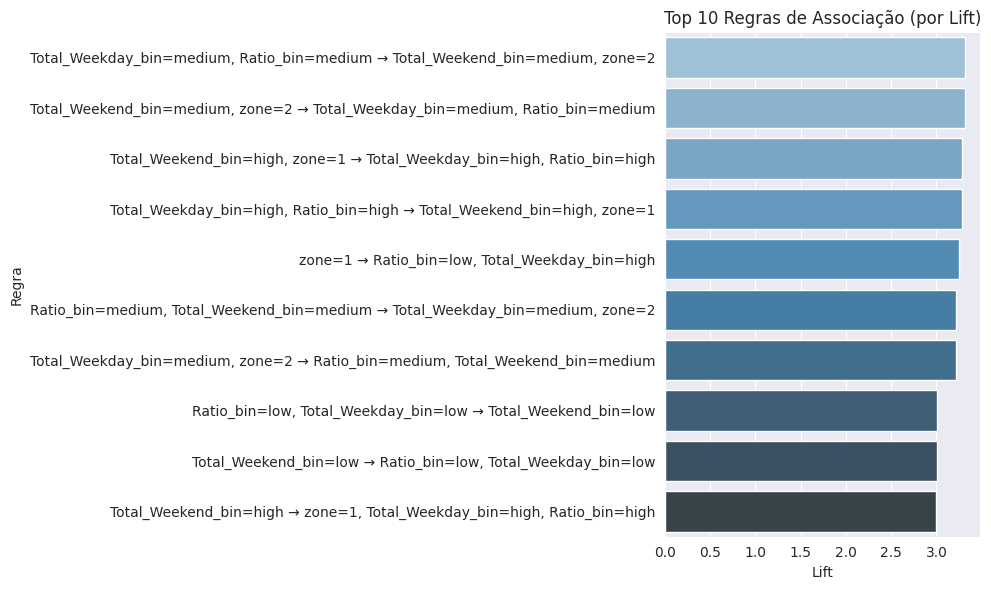

In [146]:
# Selecionar as 10 regras com maior lift
top_rules = rules_filtered.sort_values(by="lift", ascending=False).head(10).copy()

# Transformar conjuntos em strings para visualização
top_rules["antecedents_str"] = top_rules["antecedents"].apply(lambda x: ', '.join(list(x)))
top_rules["consequents_str"] = top_rules["consequents"].apply(lambda x: ', '.join(list(x)))

# Criar a label combinada para o eixo y
top_rules["rule"] = top_rules["antecedents_str"] + " → " + top_rules["consequents_str"]

# Plotar gráfico de barras horizontais com lift
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_rules,
    y="rule",
    x="lift",
    palette="Blues_d"
)
plt.title("Top 10 Regras de Associação (por Lift)")
plt.xlabel("Lift")
plt.ylabel("Regra")
plt.tight_layout()
plt.show()